In [44]:
import os
import urllib
import cv2
import numpy as np
from pixellib.semantic import semantic_segmentation
from matplotlib import pyplot as plt
from PIL import Image
from IPython.display import Image

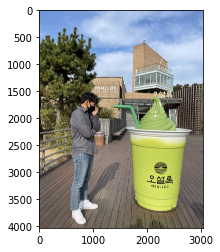

(4032, 3024, 3)


In [33]:
#경로 설정
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/image3.jpg'  
img_orig = cv2.imread(img_path) 

plt.imshow(cv2.cvtColor(img_orig, cv2.COLOR_BGR2RGB))
plt.show()
print(img_orig.shape)

In [3]:
# 저장할 파일 이름을 결정합니다
model_dir = os.getenv('HOME')+'/aiffel/human_segmentation/models'
model_file = os.path.join(model_dir, 'deeplabv3_xception_tf_dim_ordering_tf_kernels.h5')

# PixelLib가 제공하는 모델의 url입니다
model_url = 'https://github.com/ayoolaolafenwa/PixelLib/releases/download/1.1/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5'

# 다운로드를 시작합니다
urllib.request.urlretrieve(model_url, model_file)

('/aiffel/aiffel/human_segmentation/models/deeplabv3_xception_tf_dim_ordering_tf_kernels.h5',
 <http.client.HTTPMessage at 0x7f7b61e532b0>)

In [4]:
#모델 생성
model = semantic_segmentation()
model.load_pascalvoc_model(model_file)
#모델에 이미지 입력
segvalues, output = model.segmentAsPascalvoc(img_path)

In [5]:
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

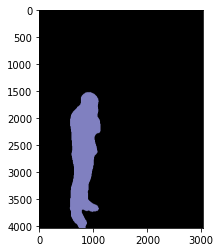

background
person


In [6]:
plt.imshow(output)
plt.show()

#어떤 물체가 있는지 보기
for class_id in segvalues['class_ids']:
    print(LABEL_NAMES[class_id])

In [7]:
segvalues

{'class_ids': array([ 0, 15]),
 'masks': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]])}

In [8]:
# 아래 코드를 이해하지 않아도 좋습니다
# PixelLib에서 그대로 가져온 코드입니다
# 주목해야 할 것은 생상 코드 결과물이예요!
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

colormap[:20]

array([[  0,   0,   0],
       [128,   0,   0],
       [  0, 128,   0],
       [128, 128,   0],
       [  0,   0, 128],
       [128,   0, 128],
       [  0, 128, 128],
       [128, 128, 128],
       [ 64,   0,   0],
       [192,   0,   0],
       [ 64, 128,   0],
       [192, 128,   0],
       [ 64,   0, 128],
       [192,   0, 128],
       [ 64, 128, 128],
       [192, 128, 128],
       [  0,  64,   0],
       [128,  64,   0],
       [  0, 192,   0],
       [128, 192,   0]])

(4032, 3024)


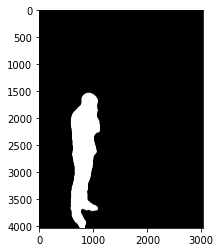

In [9]:
#색상 바꿔주기 BGRtoRGB
seg_color = (128,128,192)
# output의 픽셀 별로 색상이 seg_color와 같다면 1(True), 다르다면 0(False)이 됩니다
seg_map = np.all(output==seg_color, axis=-1)
print(seg_map.shape)
plt.imshow(seg_map, cmap='gray')
plt.show()

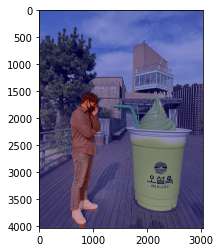

In [10]:
img_show = img_orig.copy()

# True과 False인 값을 각각 255과 0으로 바꿔줍니다
img_mask = seg_map.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꿔봅니다
color_mask = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

# 원본 이미지와 마스크를 적당히 합쳐봅니다
# 0.6과 0.4는 두 이미지를 섞는 비율입니다.
img_show = cv2.addWeighted(img_show, 0.6, color_mask, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

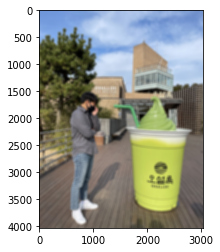

In [20]:
# (13,13)은 blurring kernel size를 뜻합니다
# 다양하게 바꿔보세요
img_orig_blur = cv2.blur(img_orig, (50,50))  
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

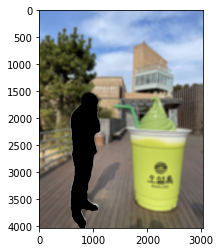

In [21]:
#흐려진 이미지에서 배경만 추출
img_mask_color = cv2.cvtColor(img_mask, cv2.COLOR_GRAY2BGR)
img_bg_mask = cv2.bitwise_not(img_mask_color)
img_bg_blur = cv2.bitwise_and(img_orig_blur, img_bg_mask)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

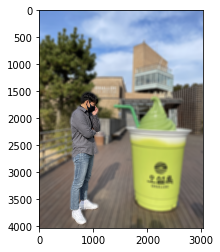

In [22]:
#배경과 사람 합치기
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

In [23]:
#크로마키 적용을 해보기 위해 합성된 이미지 저장
img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/blur_image3.jpg'
cv2.imwrite(img_path,img_concat)

True

## 크로마키 해보기

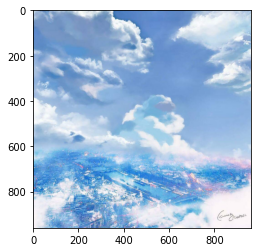

(960, 960, 3)


In [31]:
#크로마키 할 배경이미지 불러오기
chroma_img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/chroma.jpg'
chroma_img_orig = cv2.imread(chroma_img_path)

plt.imshow(cv2.cvtColor(chroma_img_orig, cv2.COLOR_BGR2RGB))
plt.show()
print(chroma_img_orig.shape)

(4032, 3024, 3)


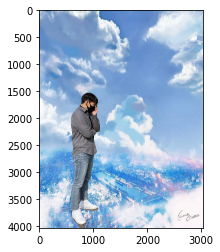

In [43]:
#인물사진과 크로마키 배경의 사이즈를 맞추기 위한 resize
img = Image.open(chroma_img_path)
image_resize = img.resize((3024, 4032))
image_resize.save(os.getenv('HOME')+'/aiffel/human_segmentation/images/chroma_resize.jpg')
#경로 재설정 하기
chroma_img_path = os.getenv('HOME')+'/aiffel/human_segmentation/images/chroma_resize.jpg'
chroma_img_orig = cv2.imread(chroma_img_path)
#크로마키 배경 사이즈 확인
print(chroma_img_orig.shape)

#위에 있는 사진과 배경사진 합치기
chroma_img_concat = np.where(img_mask_color==255, img_orig, chroma_img_orig)
plt.imshow(cv2.cvtColor(chroma_img_concat, cv2.COLOR_BGR2RGB))
plt.show()

## 고양이 사진에 대한 아웃포커싱 사진

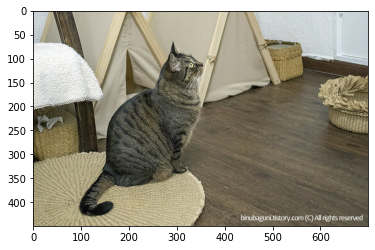

In [3]:
#경로 설정
img_path3 = os.getenv('HOME')+'/aiffel/human_segmentation/images/cat.jpg'  
img_orig3 = cv2.imread(img_path3) 

plt.imshow(cv2.cvtColor(img_orig3, cv2.COLOR_BGR2RGB))
plt.show()

In [5]:
#모델에 이미지 입력
segvalues3, output3 = model.segmentAsPascalvoc(img_path3)

In [6]:
LABEL_NAMES = [
    'background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus',
    'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike',
    'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tv'
]
len(LABEL_NAMES)

21

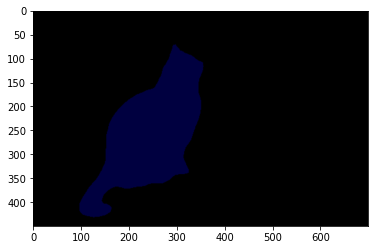

background
cat


In [7]:
plt.imshow(output3)
plt.show()

#어떤 물체가 있는지 보기
for class_id in segvalues3['class_ids']:
    print(LABEL_NAMES[class_id])

In [17]:
segvalues3

{'class_ids': array([0, 8]),
 'masks': array([[False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        ...,
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False],
        [False, False, False, ..., False, False, False]])}

In [18]:
# 아래 코드를 이해하지 않아도 좋습니다
# PixelLib에서 그대로 가져온 코드입니다
# 주목해야 할 것은 생상 코드 결과물이예요!
colormap = np.zeros((256, 3), dtype = int)
ind = np.arange(256, dtype=int)

for shift in reversed(range(8)):
    for channel in range(3):
        colormap[:, channel] |= ((ind >> channel) & 1) << shift
    ind >>= 3

colormap[:20]

array([[  0,   0,   0],
       [128,   0,   0],
       [  0, 128,   0],
       [128, 128,   0],
       [  0,   0, 128],
       [128,   0, 128],
       [  0, 128, 128],
       [128, 128, 128],
       [ 64,   0,   0],
       [192,   0,   0],
       [ 64, 128,   0],
       [192, 128,   0],
       [ 64,   0, 128],
       [192,   0, 128],
       [ 64, 128, 128],
       [192, 128, 128],
       [  0,  64,   0],
       [128,  64,   0],
       [  0, 192,   0],
       [128, 192,   0]])

In [19]:
#고양이를 나타내는건 8번이다.
colormap[8]

array([64,  0,  0])

(450, 700)


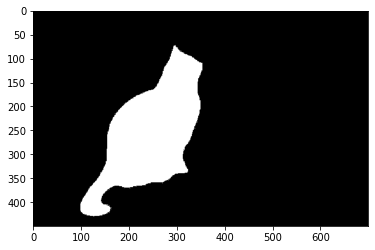

In [20]:
#색상 바꿔주기 BGRtoRGB
seg_color = (0,0,64)
# output의 픽셀 별로 색상이 seg_color와 같다면 1(True), 다르다면 0(False)이 됩니다
seg_map = np.all(output==seg_color, axis=-1)
print(seg_map.shape)
plt.imshow(seg_map, cmap='gray')
plt.show()

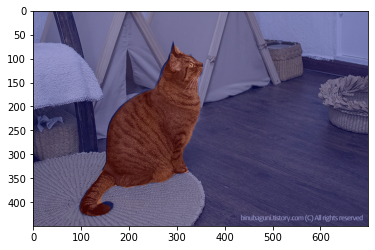

In [21]:
img_show = img_orig3.copy()

# True과 False인 값을 각각 255과 0으로 바꿔줍니다
img_mask3 = seg_map.astype(np.uint8) * 255

# 255와 0을 적당한 색상으로 바꿔봅니다
color_mask3 = cv2.applyColorMap(img_mask, cv2.COLORMAP_JET)

# 원본 이미지와 마스트를 적당히 합쳐봅니다
# 0.6과 0.4는 두 이미지를 섞는 비율입니다.
img_show = cv2.addWeighted(img_show, 0.6, color_mask3, 0.4, 0.0)

plt.imshow(cv2.cvtColor(img_show, cv2.COLOR_BGR2RGB))
plt.show()

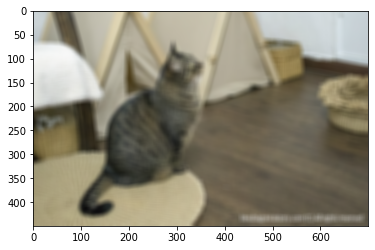

In [22]:
# (13,13)은 blurring kernel size를 뜻합니다
# 다양하게 바꿔보세요
img_orig_blur3 = cv2.blur(img_orig3, (13,13))  
plt.imshow(cv2.cvtColor(img_orig_blur, cv2.COLOR_BGR2RGB))
plt.show()

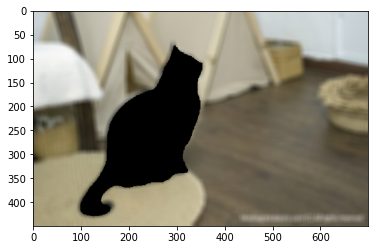

In [23]:
#흐려진 이미지에서 배경만 추출
img_mask_color3 = cv2.cvtColor(img_mask3, cv2.COLOR_GRAY2BGR)
img_bg_mask3 = cv2.bitwise_not(img_mask_color)
img_bg_blur3 = cv2.bitwise_and(img_orig_blur3, img_bg_mask3)
plt.imshow(cv2.cvtColor(img_bg_blur, cv2.COLOR_BGR2RGB))
plt.show()

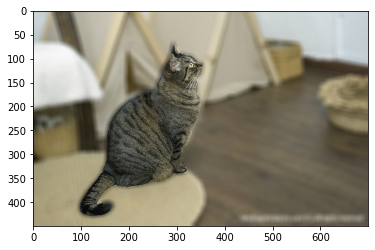

In [24]:
#배경과 고양이 합치기
img_concat = np.where(img_mask_color==255, img_orig, img_bg_blur)
plt.imshow(cv2.cvtColor(img_concat, cv2.COLOR_BGR2RGB))
plt.show()

## 인물사진의 문제점

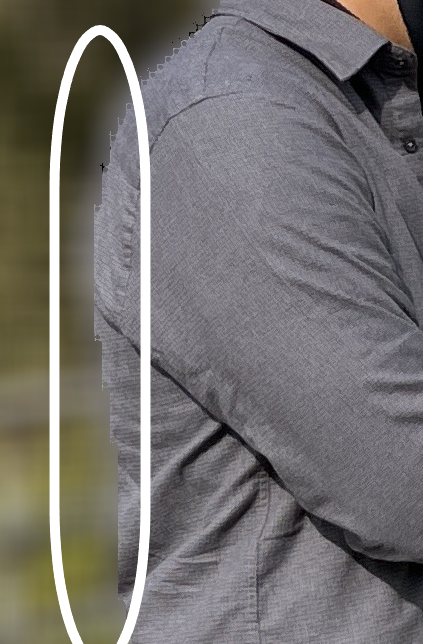

In [54]:
Image(os.getenv('HOME')+'/aiffel/human_segmentation/images/prob1.png')

부드럽게 이어지지 않고 가위로 직각으로 잘라낸듯이 이어진다.

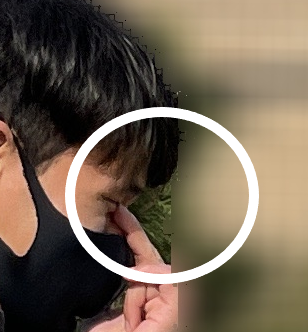

In [52]:
Image(os.getenv('HOME')+'/aiffel/human_segmentation/images/prob2.png')

제대로 블러 처리 되지 않았다.

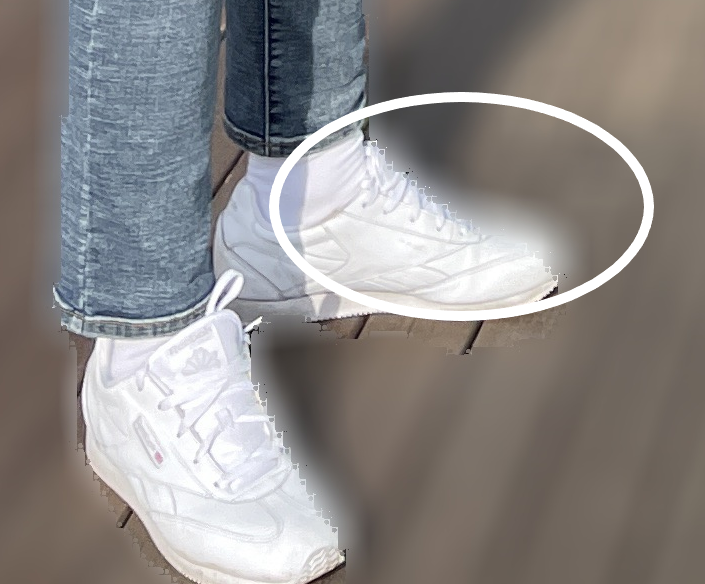

In [53]:
Image(os.getenv('HOME')+'/aiffel/human_segmentation/images/prob3.png')

블러처리가 되지 않아야되는 부분까지 블러 처리가 되었다. 


## 회고

이번 프로젝트는 그래도 좀 쉽게 했다. 이전에 했던 프로젝트들 보다 재미있게 하기도 했다. 고양이 사진 찾아보다가 고양이 강아지 나오는 유튜브영상을 1시간을 봤으니 재미가 없을 수 없었다. 고양이 말고도 크로마키로 이미지를 합치는 작업을 할때도 재밌게했다. 정작 가장 중요한 오류를 보완할 방법을 생각해내지는 못했지만 그거 하나 빼고는 할만했다. 연휴를 이용해서 여유를 가지고 했는데 결국 제출 기한이 얼마 남지 않았을때 제출을 하고야 말았다... 좀 더 성실한 생활을 해야겠다. 
